In [1]:
# ===== 0) Imports & environment =====
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
# ===== 1) Config & seeds =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# training & attack hyperparams
BATCH_SIZE = 128
TEST_BATCH = 256
EPOCHS = 5           # increase for better clean accuracy
LEARNING_RATE = 1e-3

EPS_LIST = [0.0, 0.05, 0.15, 0.25, 0.35]   # Table 1 (includes 0 for clean baseline)
PGD_STEPS = 40
PGD_ALPHA = 0.01


Device: cuda


In [3]:
# ===== 2) Data (MNIST) =====
transform = transforms.Compose([transforms.ToTensor()])   # values in [0,1]
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=TEST_BATCH, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


In [4]:
# ===== 3) Model definition =====
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.fc1   = nn.Linear(64*14*14, 128)
        self.fc2   = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x
    # penultimate features (deterministic)
    def features(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        feat = F.relu(self.fc1(x))
        return feat

model = SimpleCNN().to(DEVICE)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [5]:
# ===== 4) Training utilities =====
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

def eval_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total += x.size(0)
    return total_loss/total, total_correct/total


In [6]:
# ===== 5) Train baseline model =====
print("Starting training for {} epochs...".format(EPOCHS))
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, DEVICE)
    te_loss, te_acc = eval_model(model, test_loader, criterion, DEVICE)
    print(f"Epoch {epoch}/{EPOCHS}: Train Loss={tr_loss:.4f}, Train Acc={tr_acc:.4f} | Test Loss={te_loss:.4f}, Test Acc={te_acc:.4f}")

# Save model weights
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "mnist_cnn.pth"))

# Clean metrics
clean_train_loss, clean_train_acc = eval_model(model, train_loader, criterion, DEVICE)
clean_test_loss, clean_test_acc = eval_model(model, test_loader, criterion, DEVICE)
print(f"CLEAN: Train Acc: {clean_train_acc:.6f}  | Test Acc: {clean_test_acc:.6f}")


Starting training for 5 epochs...
Epoch 1/5: Train Loss=0.2077, Train Acc=0.9375 | Test Loss=0.0528, Test Acc=0.9829
Epoch 2/5: Train Loss=0.0550, Train Acc=0.9828 | Test Loss=0.0376, Test Acc=0.9869
Epoch 3/5: Train Loss=0.0370, Train Acc=0.9882 | Test Loss=0.0353, Test Acc=0.9876
Epoch 4/5: Train Loss=0.0270, Train Acc=0.9912 | Test Loss=0.0452, Test Acc=0.9843
Epoch 5/5: Train Loss=0.0214, Train Acc=0.9928 | Test Loss=0.0330, Test Acc=0.9896
CLEAN: Train Acc: 0.997050  | Test Acc: 0.989600


In [7]:
# ===== 6) FGSM & PGD (full-image) attack implementations =====
def fgsm_attack(model, x, y, eps, targeted=False, target_label=None):
    x_adv = x.clone().detach().to(DEVICE)
    x_adv.requires_grad = True
    model.zero_grad()
    outputs = model(x_adv)
    if targeted:
        assert target_label is not None
        loss = criterion(outputs, target_label.to(DEVICE))
        loss.backward()
        grad = x_adv.grad.data
        perturbed = x_adv - eps * grad.sign()
    else:
        loss = criterion(outputs, y.to(DEVICE))
        loss.backward()
        grad = x_adv.grad.data
        perturbed = x_adv + eps * grad.sign()
    perturbed = torch.clamp(perturbed, 0.0, 1.0).detach()
    return perturbed

def pgd_attack(model, x, y, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=False, target_label=None):
    model.eval()
    x_orig = x.clone().detach().to(DEVICE)
    perturbed = x_orig.clone().detach()
    # random start in L_inf ball
    perturbed = perturbed + torch.empty_like(perturbed).uniform_(-eps, eps)
    perturbed = torch.clamp(perturbed, 0.0, 1.0)
    for _ in range(iters):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        model.zero_grad()
        if targeted:
            assert target_label is not None
            loss = criterion(outputs, target_label.to(DEVICE))
            loss.backward()
            grad = perturbed.grad.data
            perturbed = perturbed - alpha * grad.sign()
        else:
            loss = criterion(outputs, y.to(DEVICE))
            loss.backward()
            grad = perturbed.grad.data
            perturbed = perturbed + alpha * grad.sign()
        # projection to L_inf ball around x_orig
        perturbed = torch.max(torch.min(perturbed, x_orig + eps), x_orig - eps)
        perturbed = torch.clamp(perturbed, 0.0, 1.0).detach()
    return perturbed

def fgsm_batch(model, x, y, eps, targeted=False, target_label=None):
    return fgsm_attack(model, x, y, eps, targeted=targeted, target_label=target_label)

def pgd_batch(model, x, y, eps, targeted=False, target_label=None):
    return pgd_attack(model, x, y, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=targeted, target_label=target_label)


Evaluating full-image attacks (Table 1) for epsilons: [0.0, 0.05, 0.15, 0.25, 0.35]
Eps=0.000 | FGSM-Untargeted Acc(orig)=0.9896 | FGSM-Targeted Acc(orig)=0.9896, TargetSuccess=0.0009 | PGD-Untargeted Acc(orig)=0.9896 | PGD-Targeted Acc(orig)=0.9896, TargetSuccess=0.0009
Eps=0.050 | FGSM-Untargeted Acc(orig)=0.9579 | FGSM-Targeted Acc(orig)=0.9805, TargetSuccess=0.0062 | PGD-Untargeted Acc(orig)=0.9486 | PGD-Targeted Acc(orig)=0.9822, TargetSuccess=0.0074
Eps=0.150 | FGSM-Untargeted Acc(orig)=0.6369 | FGSM-Targeted Acc(orig)=0.8225, TargetSuccess=0.0908 | PGD-Untargeted Acc(orig)=0.1152 | PGD-Targeted Acc(orig)=0.5785, TargetSuccess=0.3977
Eps=0.250 | FGSM-Untargeted Acc(orig)=0.1316 | FGSM-Targeted Acc(orig)=0.2676, TargetSuccess=0.3693 | PGD-Untargeted Acc(orig)=0.0000 | PGD-Targeted Acc(orig)=0.0018, TargetSuccess=0.9971
Eps=0.350 | FGSM-Untargeted Acc(orig)=0.0507 | FGSM-Targeted Acc(orig)=0.0209, TargetSuccess=0.4297 | PGD-Untargeted Acc(orig)=0.0000 | PGD-Targeted Acc(orig)=0.000

,Clean Accuracy (test),eps=0.000,eps=0.050,eps=0.150,eps=0.250,eps=0.350
FGSM-Untargeted,0.9896,0.9896,0.9579,0.6369,0.1316,0.0507
FGSM-Targeted,0.9896,0.9896,0.9805,0.8225,0.2676,0.0209
PGD-Untargeted,0.9896,0.9896,0.9486,0.1152,0.0000,0.0000
PGD-Targeted,0.9896,0.9896,0.9822,0.5785,0.0018,0.0000


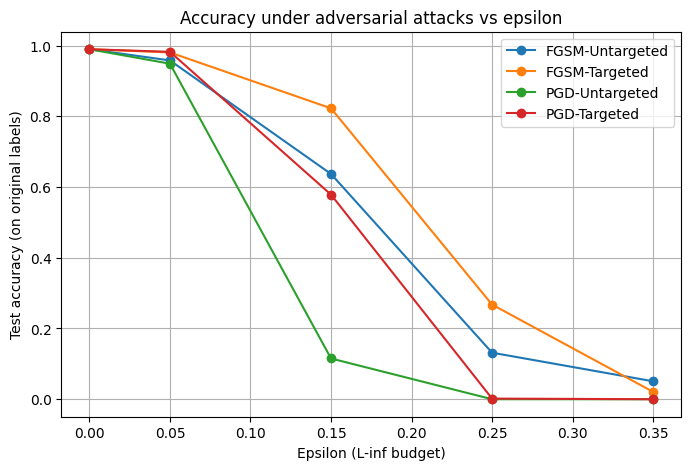

Saved plot: outputs/accuracy_vs_eps.png


In [8]:
# ===== 7) Evaluate full-image attacks (Table 1) =====
def evaluate_attack_on_loader(model, loader, attack_fn, eps, targeted=False, target_fn=None, device=DEVICE, verbose=True):
    model.eval()
    total = 0
    correct_orig = 0
    correct_target = 0
    it = loader
    if verbose:
        it = tqdm(loader, desc=f"Eval eps={eps:.3f} {'targeted' if targeted else 'untargeted'}")
    for data, target in it:
        data, target = data.to(device), target.to(device)
        if targeted:
            assert target_fn is not None
            target_labels = target_fn(target)
            xadv = attack_fn(model, data, target, eps, targeted=True, target_label=target_labels)
        else:
            xadv = attack_fn(model, data, target, eps, targeted=False)
        with torch.no_grad():
            outputs = model(xadv)
            preds = outputs.argmax(dim=1)
        total += target.size(0)
        correct_orig += (preds == target).sum().item()
        if targeted:
            correct_target += (preds == target_labels).sum().item()
    acc_orig = correct_orig / total
    acc_target = (correct_target / total) if targeted else None
    return acc_orig, acc_target

def next_label_fn(y):
    return ((y + 1) % 10).to(torch.long)

results_table = {
    "FGSM-Untargeted": [],
    "FGSM-Targeted": [],
    "PGD-Untargeted": [],
    "PGD-Targeted": []
}
print("Evaluating full-image attacks (Table 1) for epsilons:", EPS_LIST)
for eps in EPS_LIST:
    acc_fgsm_unt, _ = evaluate_attack_on_loader(model, test_loader, fgsm_batch, eps, targeted=False, verbose=False)
    acc_fgsm_tar, success_fgsm_tar = evaluate_attack_on_loader(model, test_loader, fgsm_batch, eps, targeted=True, target_fn=next_label_fn, verbose=False)
    acc_pgd_unt, _ = evaluate_attack_on_loader(model, test_loader, pgd_batch, eps, targeted=False, verbose=False)
    acc_pgd_tar, success_pgd_tar = evaluate_attack_on_loader(model, test_loader, pgd_batch, eps, targeted=True, target_fn=next_label_fn, verbose=False)

    results_table["FGSM-Untargeted"].append(acc_fgsm_unt)
    results_table["FGSM-Targeted"].append(acc_fgsm_tar)
    results_table["PGD-Untargeted"].append(acc_pgd_unt)
    results_table["PGD-Targeted"].append(acc_pgd_tar)

    print(f"Eps={eps:.3f} | FGSM-Untargeted Acc(orig)={acc_fgsm_unt:.4f} | FGSM-Targeted Acc(orig)={acc_fgsm_tar:.4f}, TargetSuccess={success_fgsm_tar:.4f} | PGD-Untargeted Acc(orig)={acc_pgd_unt:.4f} | PGD-Targeted Acc(orig)={acc_pgd_tar:.4f}, TargetSuccess={success_pgd_tar:.4f}")

# Save table CSV
attack_types = ["FGSM-Untargeted", "FGSM-Targeted", "PGD-Untargeted", "PGD-Targeted"]
table_df = pd.DataFrame(index=attack_types)
table_df["Clean Accuracy (test)"] = clean_test_acc
for i, eps in enumerate(EPS_LIST):
    table_df[f"eps={eps:.3f}"] = [results_table[a][i] for a in attack_types]
table_csv_path = os.path.join(OUTPUT_DIR, "attack_accuracy_table.csv")
table_df.to_csv(table_csv_path)
print("\nSaved Table 1 CSV:", table_csv_path)
display(table_df)

# Plot accuracy vs epsilon
plt.figure(figsize=(8,5))
for attack in attack_types:
    plt.plot(EPS_LIST, results_table[attack], marker='o', label=attack)
plt.xlabel("Epsilon (L-inf budget)")
plt.ylabel("Test accuracy (on original labels)")
plt.title("Accuracy under adversarial attacks vs epsilon")
plt.grid(True)
plt.legend()
plot_path = os.path.join(OUTPUT_DIR, "accuracy_vs_eps.png")
plt.savefig(plot_path, bbox_inches='tight')
plt.show()
print("Saved plot:", plot_path)



Single-sample analysis (index=123):
Original label: 6
Pred (clean): 6
Loss L(x, y_orig): 3.576278e-07

FGSM Untargeted: Pred after attack: 6
Loss L(x_adv, y_orig): 7.901280e-02

FGSM Targeted (target=7): Pred after attack: 6
Loss L(x_adv, y_orig): 6.933558e-02
Loss L(x_adv, y_target): 6.001870e+00

PGD Untargeted: Pred after attack: 5
Loss L(x_adv, y_orig): 6.417023e+00

PGD Targeted (target=7): Pred after attack: 7
Loss L(x_adv, y_orig): 5.636997e+00
Loss L(x_adv, y_target): 1.246919e-02


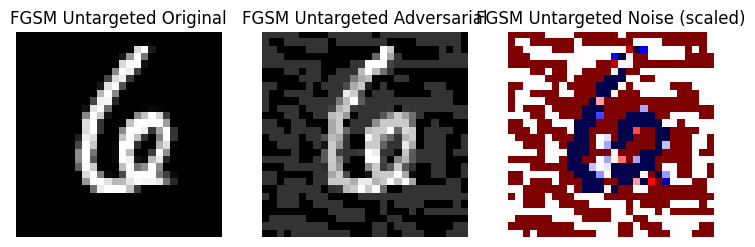

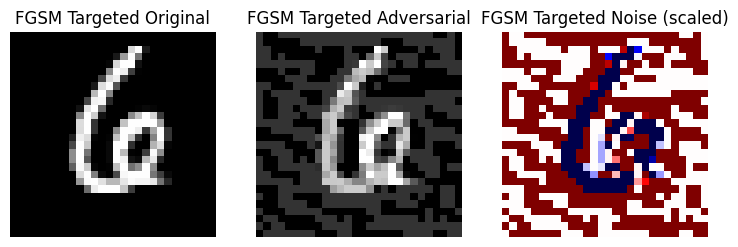

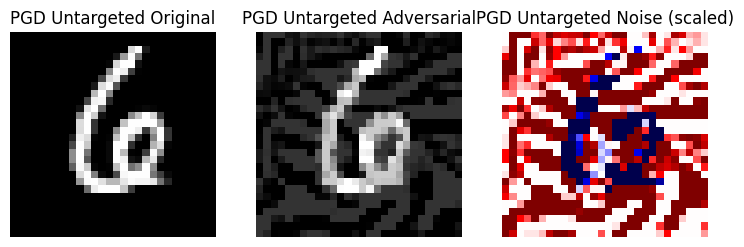

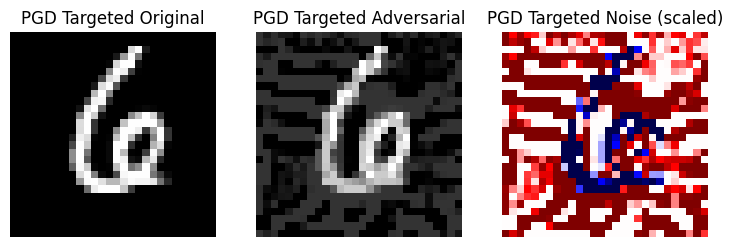

Saved visualizations to outputs/


In [9]:
# ===== 8) Single-sample analysis (visualize + losses) =====
def single_sample_analysis(model, dataset, index=0, eps=0.2):
    model.eval()
    x, y = dataset[index]
    x = x.unsqueeze(0).to(DEVICE)
    y_tensor = torch.tensor([y], dtype=torch.long).to(DEVICE)
    target_label = torch.tensor([(y + 1) % 10], dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        out_clean = model(x)
        pred_clean = out_clean.argmax(dim=1).item()
    loss_x_y = criterion(out_clean, y_tensor).item()

    # FGSM untargeted
    x_fgsm_unt = fgsm_attack(model, x, y_tensor, eps, targeted=False)
    out_fgsm_unt = model(x_fgsm_unt)
    pred_fgsm_unt = out_fgsm_unt.argmax(dim=1).item()
    loss_xadv_y_fgsm_unt = criterion(out_fgsm_unt, y_tensor).item()

    # FGSM targeted
    x_fgsm_tar = fgsm_attack(model, x, y_tensor, eps, targeted=True, target_label=target_label)
    out_fgsm_tar = model(x_fgsm_tar)
    pred_fgsm_tar = out_fgsm_tar.argmax(dim=1).item()
    loss_xadv_y_fgsm_tar = criterion(out_fgsm_tar, y_tensor).item()
    loss_xadv_target_fgsm_tar = criterion(out_fgsm_tar, target_label).item()

    # PGD untargeted
    x_pgd_unt = pgd_attack(model, x, y_tensor, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=False)
    out_pgd_unt = model(x_pgd_unt)
    pred_pgd_unt = out_pgd_unt.argmax(dim=1).item()
    loss_xadv_y_pgd_unt = criterion(out_pgd_unt, y_tensor).item()

    # PGD targeted
    x_pgd_tar = pgd_attack(model, x, y_tensor, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=True, target_label=target_label)
    out_pgd_tar = model(x_pgd_tar)
    pred_pgd_tar = out_pgd_tar.argmax(dim=1).item()
    loss_xadv_y_pgd_tar = criterion(out_pgd_tar, y_tensor).item()
    loss_xadv_target_pgd_tar = criterion(out_pgd_tar, target_label).item()

    return {
        "index": index,
        "orig_label": int(y),
        "pred_clean": int(pred_clean),
        "loss_x_y": loss_x_y,
        "fgsm_unt": {"xadv": x_fgsm_unt.detach().cpu(), "pred": pred_fgsm_unt, "loss_xadv_y": loss_xadv_y_fgsm_unt},
        "fgsm_tar": {"xadv": x_fgsm_tar.detach().cpu(), "pred": pred_fgsm_tar, "loss_xadv_y": loss_xadv_y_fgsm_tar, "loss_xadv_target": loss_xadv_target_fgsm_tar, "target_label": int(target_label.cpu())},
        "pgd_unt": {"xadv": x_pgd_unt.detach().cpu(), "pred": pred_pgd_unt, "loss_xadv_y": loss_xadv_y_pgd_unt},
        "pgd_tar": {"xadv": x_pgd_tar.detach().cpu(), "pred": pred_pgd_tar, "loss_xadv_y": loss_xadv_y_pgd_tar, "loss_xadv_target": loss_xadv_target_pgd_tar, "target_label": int(target_label.cpu())},
        "x": x.detach().cpu()
    }

def show_image_triplet(x_orig, x_adv, title_prefix="", savepath=None):
    x_orig_np = x_orig.squeeze().numpy()
    x_adv_np = x_adv.squeeze().numpy()
    delta = x_adv_np - x_orig_np
    dmin, dmax = delta.min(), delta.max()
    if abs(dmax - dmin) < 1e-12:
        delta_vis = np.zeros_like(delta)
    else:
        delta_vis = (delta - dmin) / (dmax - dmin)
    fig, axes = plt.subplots(1,3, figsize=(9,3))
    axes[0].imshow(x_orig_np, cmap='gray'); axes[0].set_title(f"{title_prefix} Original"); axes[0].axis('off')
    axes[1].imshow(x_adv_np, cmap='gray'); axes[1].set_title(f"{title_prefix} Adversarial"); axes[1].axis('off')
    axes[2].imshow(delta_vis, cmap='seismic'); axes[2].set_title(f"{title_prefix} Noise (scaled)"); axes[2].axis('off')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

SAMPLE_INDEX = 123
eps_for_sample = 0.2
single_res = single_sample_analysis(model, test_ds, index=SAMPLE_INDEX, eps=eps_for_sample)

print(f"\nSingle-sample analysis (index={SAMPLE_INDEX}):")
print("Original label:", single_res['orig_label'])
print("Pred (clean):", single_res['pred_clean'])
print(f"Loss L(x, y_orig): {single_res['loss_x_y']:.6e}")

print("\nFGSM Untargeted: Pred after attack:", single_res['fgsm_unt']['pred'])
print(f"Loss L(x_adv, y_orig): {single_res['fgsm_unt']['loss_xadv_y']:.6e}")

print("\nFGSM Targeted (target={}): Pred after attack: {}".format(single_res['fgsm_tar']['target_label'], single_res['fgsm_tar']['pred']))
print(f"Loss L(x_adv, y_orig): {single_res['fgsm_tar']['loss_xadv_y']:.6e}")
print(f"Loss L(x_adv, y_target): {single_res['fgsm_tar']['loss_xadv_target']:.6e}")

print("\nPGD Untargeted: Pred after attack:", single_res['pgd_unt']['pred'])
print(f"Loss L(x_adv, y_orig): {single_res['pgd_unt']['loss_xadv_y']:.6e}")

print("\nPGD Targeted (target={}): Pred after attack: {}".format(single_res['pgd_tar']['target_label'], single_res['pgd_tar']['pred']))
print(f"Loss L(x_adv, y_orig): {single_res['pgd_tar']['loss_xadv_y']:.6e}")
print(f"Loss L(x_adv, y_target): {single_res['pgd_tar']['loss_xadv_target']:.6e}")

show_image_triplet(single_res["x"], single_res["fgsm_unt"]["xadv"], title_prefix="FGSM Untargeted", savepath=os.path.join(OUTPUT_DIR,"fgsm_unt_sample.png"))
show_image_triplet(single_res["x"], single_res["fgsm_tar"]["xadv"], title_prefix="FGSM Targeted", savepath=os.path.join(OUTPUT_DIR,"fgsm_tar_sample.png"))
show_image_triplet(single_res["x"], single_res["pgd_unt"]["xadv"], title_prefix="PGD Untargeted", savepath=os.path.join(OUTPUT_DIR,"pgd_unt_sample.png"))
show_image_triplet(single_res["x"], single_res["pgd_tar"]["xadv"], title_prefix="PGD Targeted", savepath=os.path.join(OUTPUT_DIR,"pgd_tar_sample.png"))

print("Saved visualizations to outputs/")



CORRECTED SPARSE FGSM: Fraction of Pixels Attacked (eps=0.25)
Pixel Fraction | FGSM ASR | Pixels Modified | % of Image
------------------------------------------------------------
        0.001 |    0.020 |               0 |        0.1%
        0.005 |    0.024 |               3 |        0.5%
        0.010 |    0.026 |               7 |        1.0%
        0.050 |    0.126 |              39 |        5.0%
        0.100 |    0.310 |              78 |       10.0%
        0.200 |    0.580 |             156 |       20.0%
        0.500 |    0.782 |             392 |       50.0%
        1.000 |    0.858 |             784 |      100.0%


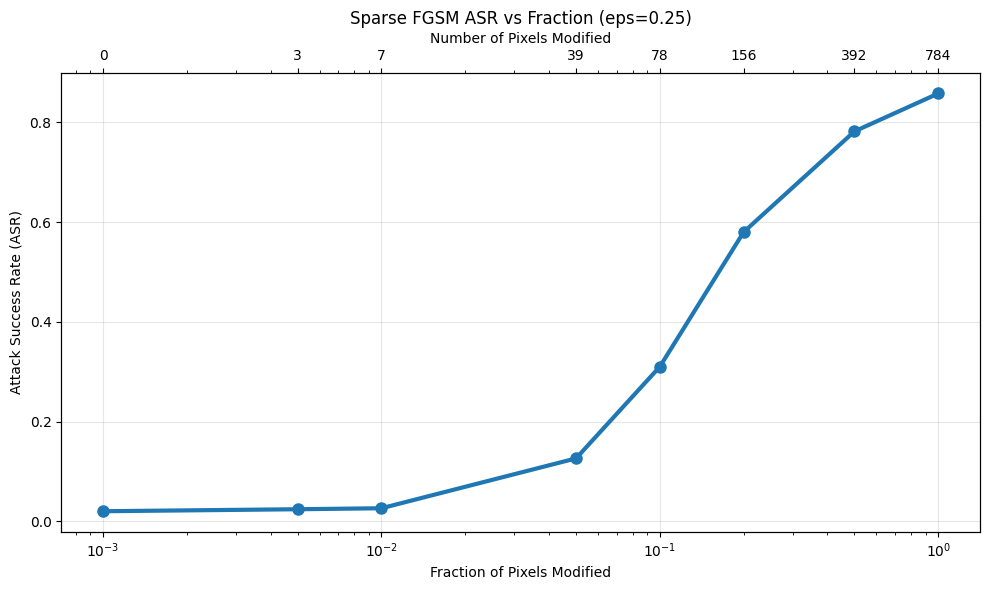


ANALYSIS OF SPARSE ATTACK RESULTS:
✅ REASONABLE: ASR increases as fraction increases.


In [10]:
# ===== 9) Corrected Sparse FGSM experiment (Fraction of pixels attacked) =====
def corrected_sparse_fgsm_attack(model, x, y, eps, pixel_fraction=0.1):
    """
    Corrected sparse FGSM:
      - compute gradient, pick top-k pixels by gradient magnitude per-sample,
      - apply FGSM sign update only on those pixels.
    """
    x_adv = x.clone().detach().to(DEVICE)
    x_adv.requires_grad = True
    model.zero_grad()
    outputs = model(x_adv)
    loss = F.cross_entropy(outputs, y.to(DEVICE))
    loss.backward()
    grad = x_adv.grad.data  # shape (B,C,H,W)
    grad_magnitudes = grad.abs()
    batch_size, channels, height, width = x.shape
    total_pixels = channels * height * width
    n_pixels_to_modify = max(1, int(total_pixels * pixel_fraction))

    grad_flat = grad_magnitudes.view(batch_size, -1)
    values, indices = torch.topk(grad_flat, n_pixels_to_modify, dim=1)
    mask = torch.zeros_like(grad_flat)
    mask.scatter_(1, indices, 1.0)
    mask = mask.view(grad.shape)

    perturbation = eps * grad.sign() * mask
    perturbed = x_adv + perturbation
    perturbed = torch.clamp(perturbed, 0.0, 1.0).detach()
    return perturbed, mask

def evaluate_corrected_sparse_attacks(model, test_ds):
    print("\n" + "="*70)
    print("CORRECTED SPARSE FGSM: Fraction of Pixels Attacked (eps=0.25)")
    print("="*70)
    pixel_fractions = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
    eps_sparse = 0.25   # user-requested epsilon for this experiment
    results = {'FGSM': []}
    test_loader = DataLoader(test_ds, batch_size=500, shuffle=True)
    images, labels = next(iter(test_loader))
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    print("Pixel Fraction | FGSM ASR | Pixels Modified | % of Image")
    print("-" * 60)
    for pixel_fraction in pixel_fractions:
        adv_fgsm, mask_fgsm = corrected_sparse_fgsm_attack(model, images, labels, eps_sparse, pixel_fraction)
        with torch.no_grad():
            preds_fgsm = model(adv_fgsm).argmax(dim=1)
            asr_fgsm = (preds_fgsm != labels).float().mean().item()
        results['FGSM'].append(asr_fgsm)
        total_pixels = images[0].numel()
        pixels_modified = int(total_pixels * pixel_fraction)
        percent_image = pixel_fraction * 100
        print(f"{pixel_fraction:13.3f} | {asr_fgsm:8.3f} | {pixels_modified:15} | {percent_image:10.1f}%")
    # Plot ASR vs fraction (log-scaled x)
    plt.figure(figsize=(10,6))
    plt.plot(pixel_fractions, results['FGSM'], 'o-', linewidth=3, markersize=8)
    plt.xlabel('Fraction of Pixels Modified')
    plt.ylabel('Attack Success Rate (ASR)')
    plt.title(f'Sparse FGSM ASR vs Fraction (eps={eps_sparse})')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    ax = plt.gca()
    ax2 = ax.twiny()
    total_pixels = 28 * 28
    pixel_counts = [int(f * total_pixels) for f in pixel_fractions]
    ax2.set_xscale('log')
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(pixel_fractions)
    ax2.set_xticklabels(pixel_counts)
    ax2.set_xlabel('Number of Pixels Modified')
    plt.tight_layout()
    sparse_plot_path = os.path.join(OUTPUT_DIR, "final_sparse_attack_results.png")
    plt.savefig(sparse_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    # brief automated check
    print("\nANALYSIS OF SPARSE ATTACK RESULTS:")
    if results['FGSM'][0] > 0.5:
        print("⚠️  SUSPICIOUS: Very high ASR with very few pixels (investigate).")
    else:
        print("✅ REASONABLE: ASR increases as fraction increases.")
    return results

sparse_results = evaluate_corrected_sparse_attacks(model, test_ds)




EXPERIMENT: Feature Space Visualization and Saliency Maps


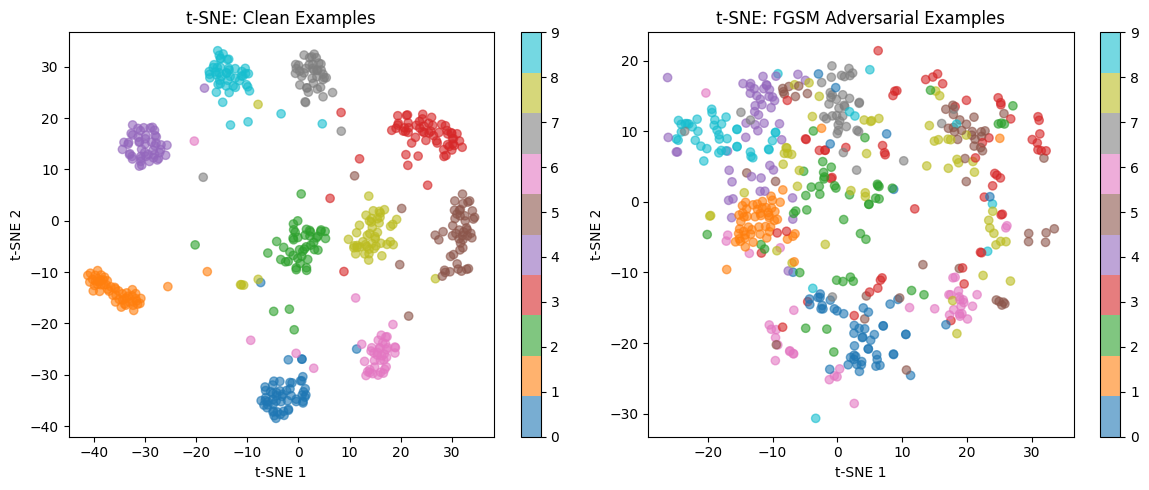

Saved t-SNE plot: outputs/tsne_feature_space.png
Generating saliency maps for a small batch (5 samples)...


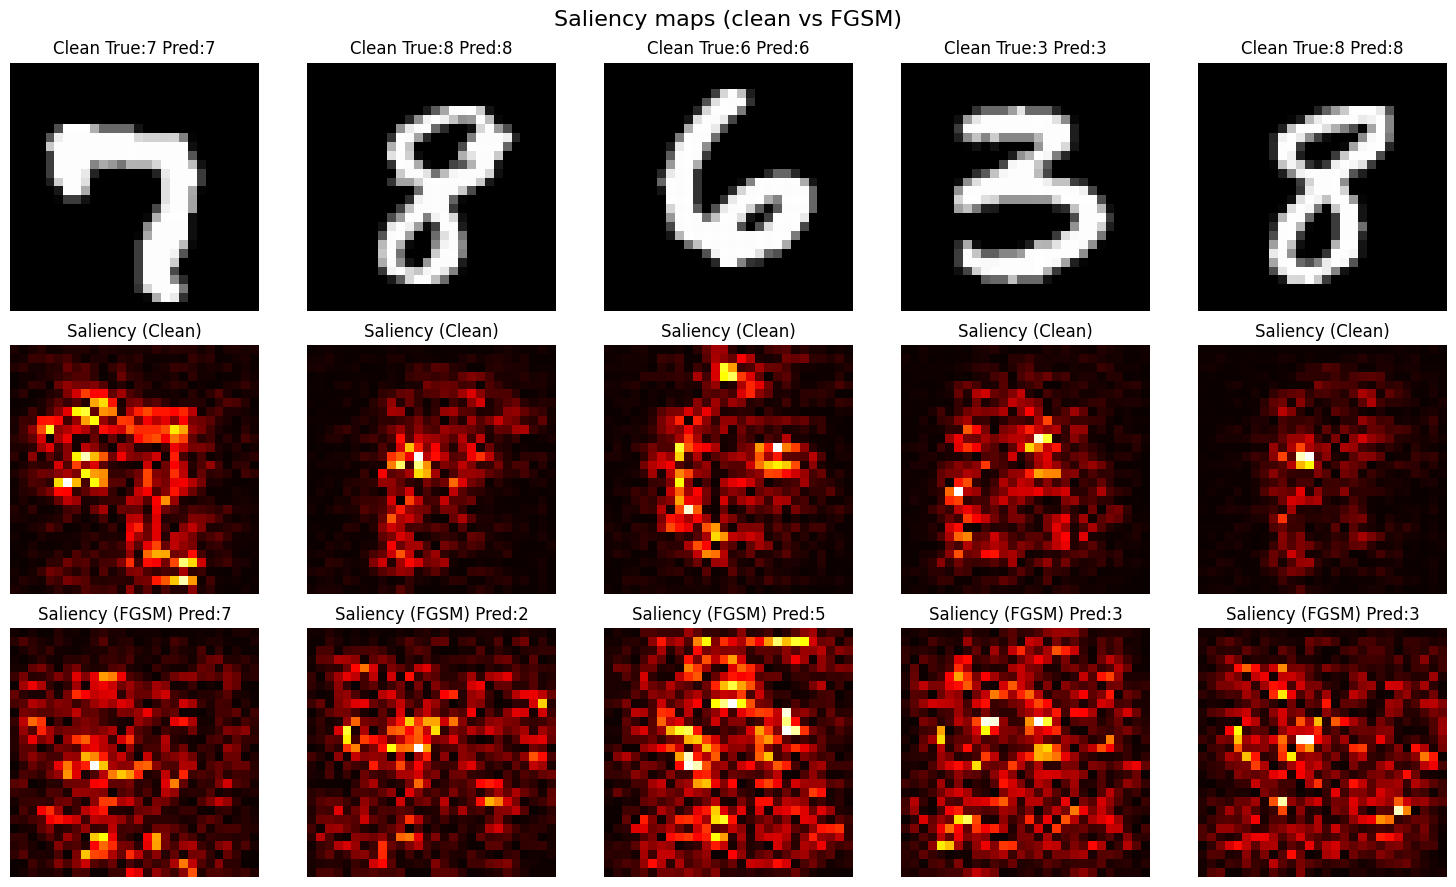

Saved saliency maps: outputs/saliency_maps.png

All completed. Files saved to: outputs
- attack_accuracy_table.csv, accuracy_vs_eps.png
- fgsm/pgd sample images in outputs/
- final_sparse_attack_results.png
- tsne_feature_space.png, saliency_maps.png


In [11]:
# ===== 10) Feature-space visualization & saliency =====
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.features = None
        def hook(module, input, output):
            self.features = output
        self.model.fc1.register_forward_hook(hook)
    def forward(self, x):
        _ = self.model(x)
        return self.features

def compute_saliency_map(model, image, target_class=None):
    # image shape (1,1,H,W) or (B,1,H,W)
    image = image.clone().detach().requires_grad_(True).to(DEVICE)
    model.zero_grad()
    output = model(image)
    if target_class is None:
        target_class = output.argmax(dim=1)
    # compute score: if single sample scalar target_class, pick corresponding logit
    if target_class.dim() == 0:
        score = output[0, target_class]
    else:
        # batched: sum logits for target indices
        score = output[torch.arange(output.size(0)), target_class].sum()
    score.backward()
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)  # shape (B,H,W)
    return saliency.squeeze().cpu().numpy()

def visualize_feature_space_and_saliency(model, test_ds):
    print("\n" + "="*60)
    print("EXPERIMENT: Feature Space Visualization and Saliency Maps")
    print("="*60)
    feature_extractor = FeatureExtractor(model).to(DEVICE)
    n_samples = 1000
    # sample subset for features
    test_loader_small = DataLoader(test_ds, batch_size=n_samples, shuffle=True)
    images, labels = next(iter(test_loader_small))
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    # make adversarials (FGSM) for visualization
    fgsm_eps_plot = 0.3
    def fgsm_batch_simple(model, x, y, eps):
        x_adv = x.clone().detach().to(DEVICE)
        x_adv.requires_grad = True
        outputs = model(x_adv)
        loss = F.cross_entropy(outputs, y.to(DEVICE))
        model.zero_grad()
        loss.backward()
        grad = x_adv.grad.data
        perturbed = x_adv + eps * grad.sign()
        return torch.clamp(perturbed, 0.0, 1.0).detach()
    adv_images_fgsm = fgsm_batch_simple(model, images, labels, eps=fgsm_eps_plot)
    # Extract features (penultimate)
    with torch.no_grad():
        features_clean = feature_extractor(images).cpu().numpy()
        features_fgsm  = feature_extractor(adv_images_fgsm).cpu().numpy()
    labels_np = labels.cpu().numpy()
    # t-SNE on subset (to keep it fast choose subset for t-SNE)
    n_tsne = 500
    indices = np.random.choice(len(features_clean), n_tsne, replace=False)
    features_combined = np.vstack([features_clean[indices], features_fgsm[indices]])
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
    features_tsne = tsne.fit_transform(features_combined)
    tsne_clean = features_tsne[:n_tsne]
    tsne_fgsm  = features_tsne[n_tsne:]
    # Plot clean vs adv (colored by class)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    scatter = plt.scatter(tsne_clean[:,0], tsne_clean[:,1], c=labels_np[indices], cmap='tab10', alpha=0.6)
    plt.colorbar(scatter); plt.title('t-SNE: Clean Examples'); plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
    plt.subplot(1,2,2)
    scatter = plt.scatter(tsne_fgsm[:,0], tsne_fgsm[:,1], c=labels_np[indices], cmap='tab10', alpha=0.6)
    plt.colorbar(scatter); plt.title('t-SNE: FGSM Adversarial Examples'); plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
    plt.tight_layout()
    tsne_path = os.path.join(OUTPUT_DIR, "tsne_feature_space.png")
    plt.savefig(tsne_path, dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved t-SNE plot:", tsne_path)
    # Saliency maps for a few random samples
    print("Generating saliency maps for a small batch (5 samples)...")
    test_loader_sample = DataLoader(test_ds, batch_size=5, shuffle=True)
    sample_images, sample_labels = next(iter(test_loader_sample))
    sample_images, sample_labels = sample_images.to(DEVICE), sample_labels.to(DEVICE)
    adv_fgsm_sample = fgsm_batch_simple(model, sample_images, sample_labels, eps=fgsm_eps_plot)
    saliency_clean = [compute_saliency_map(model, sample_images[i:i+1], sample_labels[i]) for i in range(len(sample_images))]
    saliency_fgsm = [compute_saliency_map(model, adv_fgsm_sample[i:i+1], sample_labels[i]) for i in range(len(sample_images))]
    n_show = len(sample_images)
    fig, axes = plt.subplots(3, n_show, figsize=(3*n_show, 9))
    if n_show == 1:
        axes = axes.reshape(3,1)
    for i in range(n_show):
        axes[0,i].imshow(sample_images[i,0].cpu().numpy(), cmap='gray')
        with torch.no_grad():
            pred_clean = model(sample_images[i:i+1]).argmax(dim=1).item()
        axes[0,i].set_title(f'Clean True:{sample_labels[i].item()} Pred:{pred_clean}'); axes[0,i].axis('off')
        axes[1,i].imshow(saliency_clean[i], cmap='hot'); axes[1,i].set_title('Saliency (Clean)'); axes[1,i].axis('off')
        axes[2,i].imshow(saliency_fgsm[i], cmap='hot');
        with torch.no_grad():
            pred_fgsm = model(adv_fgsm_sample[i:i+1]).argmax(dim=1).item()
        axes[2,i].set_title(f'Saliency (FGSM) Pred:{pred_fgsm}'); axes[2,i].axis('off')
    plt.suptitle('Saliency maps (clean vs FGSM)', fontsize=16)
    sal_path = os.path.join(OUTPUT_DIR, "saliency_maps.png")
    plt.tight_layout()
    plt.savefig(sal_path, dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved saliency maps:", sal_path)
    return feature_extractor

feature_extractor = visualize_feature_space_and_saliency(model, test_ds)

print("\nAll completed. Files saved to:", OUTPUT_DIR)
print("- attack_accuracy_table.csv, accuracy_vs_eps.png")
print("- fgsm/pgd sample images in outputs/")
print("- final_sparse_attack_results.png")
print("- tsne_feature_space.png, saliency_maps.png")